data available at https://www.kaggle.com/datasets/surajbhandari527/ecommerce-churn-data-for-churn-prediction-models?resource=download

In [110]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import AdaBoostClassifier
import sklearn.metrics as metrics
from pickle import dump

In [14]:
data_path = Path.cwd().parent/'data'/'ecommerce_churn_data.csv'
raw_df = pd.read_csv(data_path)

In [36]:
raw_df

,CustomerID,Age,Gender,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,HoursSpentOnApp,NumberOfDevicesRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderCount,DaySinceLastOrder,CashbackAmount,Churn
0,56346,29,Male,5.0,Desktop,1,7.2,2.5,2,3,1,1,8,15,45.20,1
1,56347,45,Female,36.0,Mobile,3,20.1,4.8,4,5,3,0,50,2,320.50,0
2,56348,22,Male,2.0,Mobile,1,5.0,1.8,1,2,1,1,3,25,10.10,1
3,56349,39,Female,24.0,Desktop,2,15.3,3.9,3,4,2,0,35,5,210.90,0
4,56350,31,Male,12.0,Mobile,1,8.8,3.0,2,3,1,0,18,10,80.40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10200,9946,32,Female,25.0,Mobile,2,8.0,4.1,3,4,1,0,27,7,240.00,0
10201,9947,26,Male,9.0,Mobile,3,4.7,3.3,1,3,1,0,9,15,105.75,0
10202,9948,42,Female,35.0,Desktop,1,11.5,4.5,4,5,3,0,30,4,270.00,0
10203,9949,31,Male,16.0,Mobile,2,6.0,3.5,2,3,2,1,18,11,160.50,1


In [34]:
raw_df.describe()

,CustomerID,Age,Tenure,CityTier,WarehouseToHome,HoursSpentOnApp,NumberOfDevicesRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderCount,DaySinceLastOrder,CashbackAmount,Churn
count,10205.000000,10205.000000,10204.000000,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000,10205.000000
mean,29677.581872,35.193043,19.685515,2.007349,9.887428,3.343626,2.833807,3.504459,1.861832,0.216267,21.453895,8.891720,157.953214,0.238707
std,25617.824693,9.625432,14.475853,0.826741,5.481747,1.133353,0.921249,1.162892,0.920454,0.411718,18.955878,8.283807,107.627670,0.426314
min,307.000000,18.000000,1.000000,1.000000,0.500000,0.800000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5097.000000,28.000000,8.000000,1.000000,6.000000,2.500000,2.000000,3.000000,1.000000,0.000000,9.000000,3.000000,75.000000,0.000000
50%,9711.000000,33.000000,16.000000,2.000000,9.000000,3.400000,3.000000,4.000000,2.000000,0.000000,18.000000,6.000000,140.000000,0.000000
75%,56429.000000,42.000000,28.000000,3.000000,13.000000,4.100000,3.000000,4.000000,2.000000,0.000000,28.000000,12.000000,220.000000,0.000000
max,56760.000000,65.000000,85.000000,3.000000,35.000000,8.500000,5.000000,5.000000,5.000000,1.000000,250.000000,60.000000,1120.000000,1.000000


In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10205 entries, 0 to 10204
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 10205 non-null  int64  
 1   Age                        10205 non-null  int64  
 2   Gender                     10205 non-null  object 
 3   Tenure                     10204 non-null  float64
 4   PreferredLoginDevice       10205 non-null  object 
 5   CityTier                   10205 non-null  int64  
 6   WarehouseToHome            10205 non-null  float64
 7   HoursSpentOnApp            10205 non-null  float64
 8   NumberOfDevicesRegistered  10205 non-null  int64  
 9   SatisfactionScore          10205 non-null  int64  
 10  NumberOfAddress            10205 non-null  int64  
 11  Complain                   10205 non-null  int64  
 12  OrderCount                 10205 non-null  int64  
 13  DaySinceLastOrder          10205 non-null  int

In [20]:
n_null = (~raw_df.notna()).sum()
print(f'null values:\n{n_null}')

null values:
CustomerID                   0
Age                          0
Gender                       0
Tenure                       1
PreferredLoginDevice         0
CityTier                     0
WarehouseToHome              0
HoursSpentOnApp              0
NumberOfDevicesRegistered    0
SatisfactionScore            0
NumberOfAddress              0
Complain                     0
OrderCount                   0
DaySinceLastOrder            0
CashbackAmount               0
Churn                        0
dtype: int64


In [44]:
raw_df.Gender.value_counts()

Gender
Male      5145
Female    5058
Other        2
Name: count, dtype: int64

In [45]:
raw_df.PreferredLoginDevice.value_counts()

PreferredLoginDevice
Mobile     6509
Desktop    3696
Name: count, dtype: int64

In [17]:
n_duplicated = raw_df.duplicated().sum()
print(f'The data has {n_duplicated} duplicates')

The data has 0 duplicates


- the dataset is pretty clean
- only one missing value in the tenure column

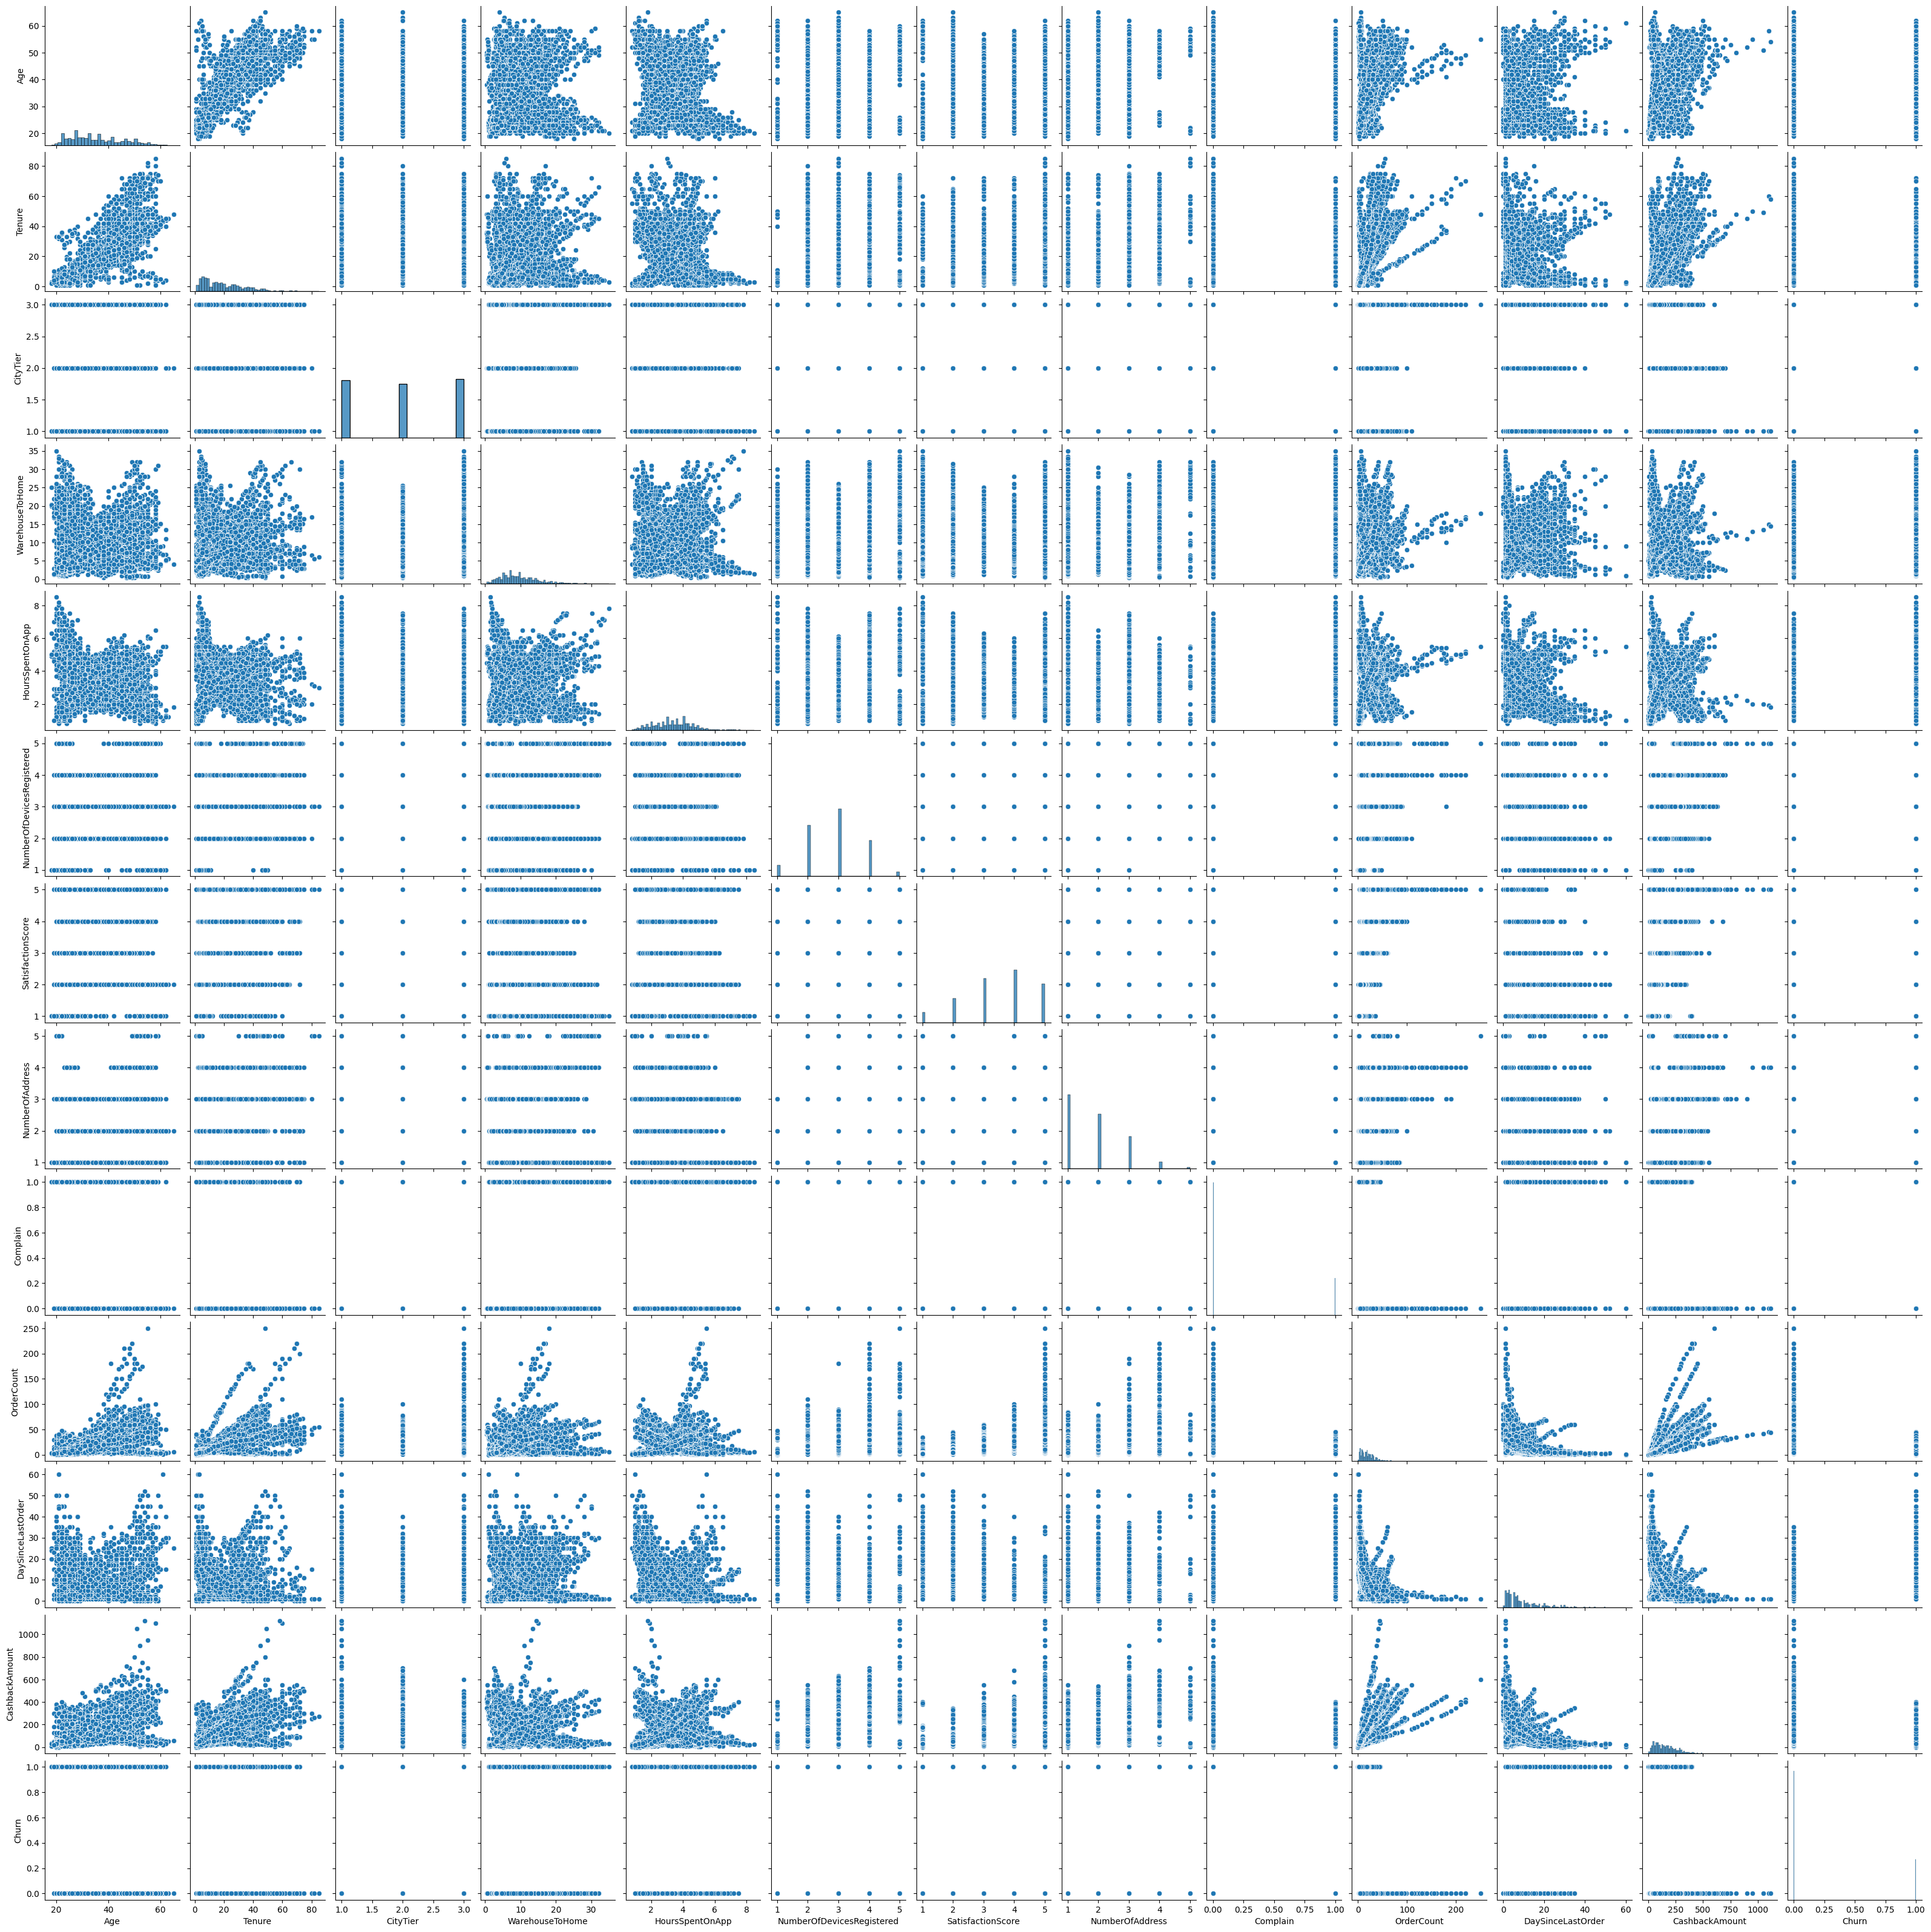

In [ ]:
sns.pairplot(raw_df)
plt.show()

In [86]:
df = raw_df.copy()
df.drop(['CustomerID'], axis=1, inplace=True)
df.fillna(df.Tenure.mean(), inplace=True)

gender_encoder = OneHotEncoder(sparse_output=False)
encoded_gender = gender_encoder.fit_transform(df[['Gender']])
encoded_gender = pd.DataFrame(encoded_gender, columns = gender_encoder.get_feature_names_out())
df.drop('Gender', axis=1, inplace=True)
df = df.join(encoded_gender)

device_encoder = OrdinalEncoder()
encoded_device = device_encoder.fit_transform(df[['PreferredLoginDevice']])
df.PreferredLoginDevice = encoded_device

In [87]:
x = df.drop('Churn',axis=1)
y = df.Churn
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)



0.9742002063983488


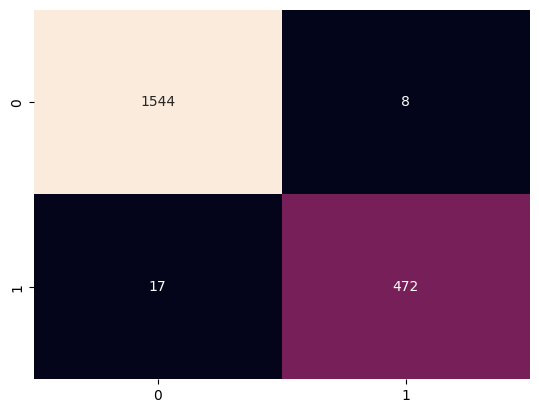

In [100]:
model = AdaBoostClassifier(random_state=42)
model.fit(xtrain, ytrain)
ypred = model.predict(xtest)

results = (ytest, ypred)
conf_matr = metrics.confusion_matrix(*results)
print(metrics.f1_score(*results))

sns.heatmap(conf_matr, annot=True, cbar=False, fmt='')
plt.show()

0.9877300613496932


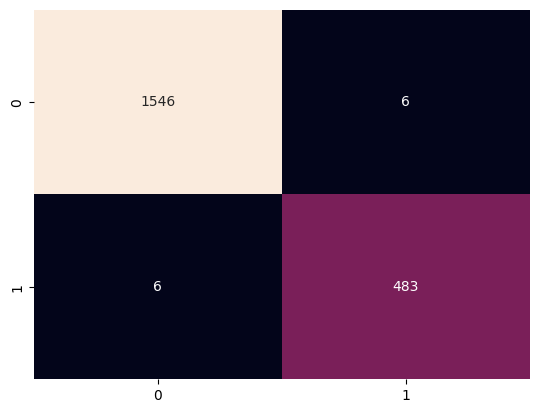

In [106]:
params = {
    'n_estimators':[100, 200, 300],
    'learning_rate':[0.01,1,1.25,1.5,1.75,1.875,],
    }
grid = GridSearchCV(model, param_grid=params, scoring='f1', n_jobs=-1)
grid.fit(xtrain, ytrain)
best_model = grid.best_estimator_

ypred = best_model.predict(xtest)

results = (ytest, ypred)
conf_matr = metrics.confusion_matrix(*results)
print(metrics.f1_score(*results))

sns.heatmap(conf_matr, annot=True, cbar=False, fmt='')
plt.show()

In [111]:
model_name = 'AdaBoost_learning_rate_1.5_n_estimators_300_random_state_42.sav'
with open('../models'+model_name,'wb') as f:
    dump(best_model, f)